In [1]:
import numpy as np
import pandas as pd

from math import sqrt
from cvxopt import matrix
from cvxopt.blas import nrm2, dot
from cvxopt.solvers import qp, socp, options
import matplotlib.pyplot as plt


ModuleNotFoundError: No module named 'cvxopt'

In [6]:
names = ['Ant', 'Bee', 'Croc', 'Dino']
n = len(names)

# матрица ковариаций, на слайдах Cov = Sigma
Cov = 0.1 * matrix(
    [[ 0.1138, -0.0137,  0.0218, -0.0102],
     [-0.0137,  0.0274, -0.0028,  0.0040],
     [ 0.0218, -0.0028,  0.0213, -0.0016],
     [-0.0102,  0.0040, -0.0016,  0.0143]])

rootCov = matrix(np.linalg.cholesky(Cov)).T
print(rootCov)

[ 1.07e-01 -1.28e-02  2.04e-02 -9.56e-03]
[ 0.00e+00  5.07e-02 -3.46e-04  5.46e-03]
[ 0.00e+00  0.00e+00  4.14e-02  9.01e-04]
[ 0.00e+00  0.00e+00  0.00e+00  3.62e-02]



### Sample portfolio 

In [10]:
MM = 1000000 # у нас столько денег
portf0 = MM * matrix([0.1, 0.2, 0.3, 0.4]) # распределим деньги по активам
portf0

<4x1 matrix, tc='d'>

In [15]:
portf0variance = (portf0.T * Cov * portf0)[0,0] #сигма в квадрате
portf0risk = sqrt(portf0variance)  # среднеквадратичное отклонение
print(portf0risk)

25105.7762278


### Portfolio expected return


In [14]:
alphas = matrix([0.01, 0.02, 0.03, 0.04]) 
# думаю, что акции подрастут на столько-то процентов, вектор матожиданий роста
portf0return = (alphas.T * portf0)[0, 0] #alpha transp * W; W -- matrix альфа т умножил на веса
print(portf0return)

30000.0


## Problem 1

Maximize the expected return for a given level of risk 

In [16]:
netInvested = MM # 1000000
maximalRisk = 25000  
#максимзируем доход, но риск не больше, чем 25к <-- хотим, чтобы такой был риск

Conic formulation:
    $$
    \begin{aligned}
    c^{T} x &\to\ \mbox{min}\\
    s_0 &= h_0 - G_0 x \\
    s_0 &\succeq 0 \\
    s_1 & = h_1 - G_1 x \\
    s_1 &\in \mathcal{C} \\
    A x &= b
    \end{aligned}
    $$

#### Constraint 0 (Linear)

Risk positive, investments positive

In [24]:
e1 = matrix(1.0) # [1]
e5 = matrix(0.0, (5,5)) 
e5[::6] = 1.0 # diagonal 1  5х5
z4 = matrix(0.0, (1,4)) # zero 1x4
o4 = matrix(1.0, (1,4)) # ones 1x4

print(z4) # четыре нуля

[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00]



In [27]:
# Generate constrains matrix G0 by adding 
G0 = matrix([[1.0], [z4]]) # 1 0 0 0 0
G0 = matrix([G0, -1.0*e5]) # прошлый вектор G0, а под ним -I => 5x6
h0 = matrix([[maximalRisk, matrix(0.0, (5,1))]]) # risc vector

print(G0)
print(h0)

[ 1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
[-1.00e+00 -0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -1.00e+00 -0.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -1.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -0.00e+00 -1.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00 -1.00e+00]

[ 2.50e+04]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]



#### Constraint 1 (Conic)

$\displaystyle s1 = {r \choose G x}$

r = sigma

In [30]:
G1 = matrix([[-1*e1, z4.T],[z4, -1.0*rootCov]])
h1 = matrix(0.0, (5,1))

print(G1)
print(h1)

[-1.00e+00  0.00e+00  0.00e+00  0.00e+00  0.00e+00]
[ 0.00e+00 -1.07e-01  1.28e-02 -2.04e-02  9.56e-03]
[ 0.00e+00 -0.00e+00 -5.07e-02  3.46e-04 -5.46e-03]
[ 0.00e+00 -0.00e+00 -0.00e+00 -4.14e-02 -9.01e-04]
[ 0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00 -3.62e-02]

[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]



#### Linear constraint
Fully invested portfolio: $\left( 0, e^T \right) x = 1000000$

In [32]:
A = matrix([[0.0], [o4]]) #
b = matrix(1.0*MM, (1,1)) #просто число 
print(A)
print(b)

[ 0.00e+00  1.00e+00  1.00e+00  1.00e+00  1.00e+00]

[ 1.00e+06]



#### Utility function   c^T --> x min

In [33]:
coeffUtil1 = matrix([0.0, -1*alphas])
print(coeffUtil1)

[ 0.00e+00]
[-1.00e-02]
[-2.00e-02]
[-3.00e-02]
[-4.00e-02]



#### Optimizer call

In [38]:
solution1 = socp(coeffUtil1, G0, h0, [G1], [h1], A, b) #коэфф утилити функций G0
#приводитли квиду удобному для оптимизатора

     pcost       dcost       gap    pres   dres   k/t
 0: -2.5036e+04 -5.0409e+04  1e+06  3e+00  2e+00  1e+00
 1: -2.5253e+04 -1.8473e+04  8e+05  2e+00  1e+00  2e+04
 2: -2.6281e+04 -2.4553e+04  1e+05  3e-01  2e-01  4e+03
 3: -3.1266e+04 -2.7973e+04  4e+04  1e-01  9e-02  4e+03
 4: -3.2092e+04 -3.1819e+04  3e+03  7e-03  6e-03  3e+02
 5: -3.2801e+04 -3.2753e+04  4e+02  1e-03  1e-03  6e+01
 6: -3.2812e+04 -3.2810e+04  1e+01  2e-05  2e-05  1e+00
 7: -3.2811e+04 -3.2811e+04  2e-01  4e-07  4e-07  2e-02
 8: -3.2811e+04 -3.2811e+04  2e-02  4e-08  4e-08  2e-03
Optimal solution found.


In [39]:
portf1 = solution1['x'][1:5]
print(sum(portf1))

1000000.0


In [41]:
portf1variance = (portf1.T * Cov * portf1)[0,0]
portf1risk = sqrt(portf1variance)
print(portf1risk) #посчитали риск

portf1return = (alphas.T * portf1)[0, 0]
print(portf1return)
# вывели риск и доходность соответственно

24999.9997172
32811.1659729


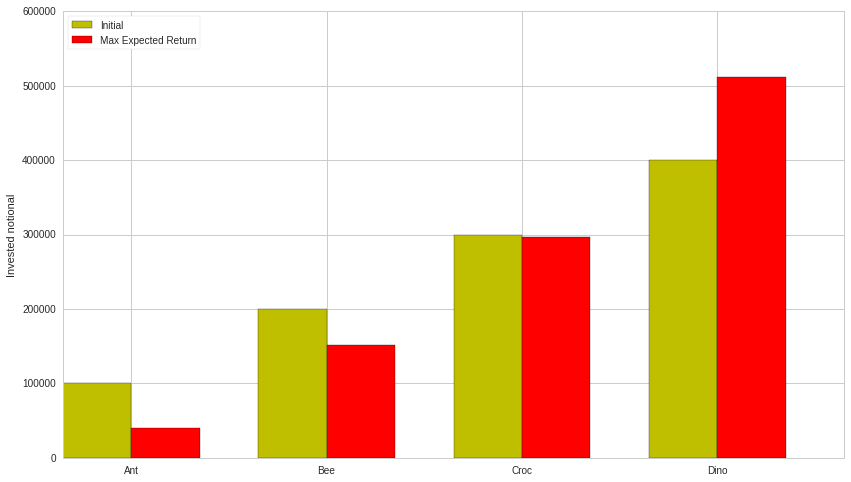

In [43]:
ind = np.arange(n)    # the horizontal locations for the groups
width = 0.35          # the width of the bars: can also be len(x) sequence
p0 = plt.bar(ind, portf0, width, color='y')
p1 = plt.bar(ind+width, portf1, width, color='r')

plt.ylabel('Invested notional')
plt.xticks(ind + width, names)
plt.legend((p0[0], p1[0]), ('Initial', 'Max Expected Return'), loc=2)

plt.show() #yellow - base portfel

## Problem 2

Minimize the risk for the expected level of return

In [45]:
coeffUtil2 = matrix([1.0, z4.T])
print(coeffUtil2)

[ 1.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]



In [46]:
minReturn = 30000

G0 = matrix([[0.0], [-1*alphas.T]])
G0 = matrix([G0, -1.0*e5])
print(G0)

h0 = matrix([[-minReturn, matrix(0.0, (5,1))]])
print(h0)

[ 0.00e+00 -1.00e-02 -2.00e-02 -3.00e-02 -4.00e-02]
[-1.00e+00 -0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -1.00e+00 -0.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -1.00e+00 -0.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -0.00e+00 -1.00e+00 -0.00e+00]
[-0.00e+00 -0.00e+00 -0.00e+00 -0.00e+00 -1.00e+00]

[-3.00e+04]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]
[ 0.00e+00]



In [48]:
solution2 = socp(coeffUtil2, G0, h0, [G1], [h1], A, b)

     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00  3.0000e+04  1e+06  3e+00  3e+00  1e+00
 1:  3.0629e+04  5.4084e+04  4e+05  1e+00  1e+00  1e+04
 2:  2.8103e+04  3.5444e+04  9e+04  2e-01  2e-01  5e+03
 3:  2.5590e+04  2.6394e+04  1e+04  3e-02  3e-02  5e+02
 4:  2.4565e+04  2.4700e+04  1e+03  4e-03  4e-03  1e+02
 5:  2.4585e+04  2.4608e+04  2e+02  5e-04  5e-04  2e+01
 6:  2.4573e+04  2.4574e+04  6e+00  2e-05  2e-05  7e-01
 7:  2.4573e+04  2.4573e+04  2e-01  7e-07  7e-07  3e-02
 8:  2.4573e+04  2.4573e+04  7e-03  2e-08  2e-08  8e-04
Optimal solution found.


In [50]:
print(solution2['sl'])

[ 9.12e+02]
[ 2.46e+04]
[ 6.53e+04]
[ 2.17e+05]
[ 2.78e+05]
[ 4.39e+05]



In [51]:
portf2 = solution2['x'][1:5]

portf2variance = (portf2.T * Cov * portf2)[0,0]
portf2risk = sqrt(portf2variance)
print(portf2risk)

portf2return = (alphas.T * portf2)[0, 0]
print(portf2return)

24572.6909609
30911.8348434


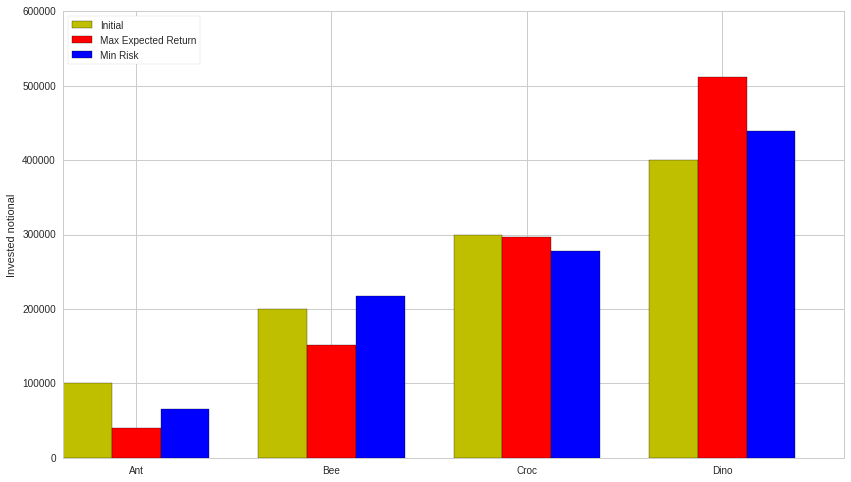

In [53]:
ind = np.arange(n)    # the horizontal locations for the groups
width = 0.25          # the width of the bars: can also be len(x) sequence
p0 = plt.bar(ind, portf0, width, color='y')
p1 = plt.bar(ind+width, portf1, width, color='r')
p2 = plt.bar(ind+width*2., portf2, width, color='b')

plt.ylabel('Invested notional')
plt.xticks(ind + width*1.5, names)
plt.legend((p0[0], p1[0], p2[0]), ('Initial', 'Max Expected Return', 'Min Risk'), loc=2)

plt.show()

### Problem 3

Markowitz mean-variance optimization. The utility function is a weighted sum of expected return and risk: 
$c = (\lambda, -\alpha^T)$, 
where $\lambda$ is a risk-aversion parameter

In [56]:
# lambda it is a risk awersion, with different lambda we can gain efficient frantier
def meanVariance(riskAversion):
    
    # utility function
    coeffUtil = matrix([riskAversion, -1.0*alphas])
    
    # investment limit plus positivity constraints
    G0 = matrix([matrix([[0.0],[o4]]), -1.0*e5])
    h0 = matrix([[MM, matrix(0.0, (5,1))]])

    # conic constraint
    G1 = matrix([[-1*e1, z4.T],[z4, -1.0*rootCov]])
    h1 = matrix(0.0, (5,1))
    
    # linear constraint = full investment
    A = matrix([[0.0], [o4]])
    b = matrix(1.0*MM, (1,1))

    # call the optimizer
    solution = socp(coeffUtil, G0, h0, [G1], [h1], A, b)

    return solution['x'][1:5]

In [58]:
pi = meanVariance(1.0)

     pcost       dcost       gap    pres   dres   k/t
 0: -2.5036e+04 -1.0400e+06  1e+06  9e-02  2e+00  1e+00
 1:  8.5157e+03 -2.4427e+05  3e+05  2e-02  5e-01  1e+04
 2:  1.6966e+03 -5.6352e+04  7e+04  5e-03  1e-01  4e+03
 3: -8.7656e+03 -5.3212e+04  5e+04  4e-03  1e-01  4e+03
 4: -1.5926e+01 -4.3320e+04  5e+04  4e-03  1e-01  5e+03
 5: -4.9642e+03 -2.4675e+04  2e+04  2e-03  4e-02  3e+03
 6: -7.5962e+03 -1.2579e+04  6e+03  5e-04  1e-02  8e+02
 7: -8.2156e+03 -9.1968e+03  1e+03  1e-04  2e-03  2e+02
 8: -8.5148e+03 -8.8761e+03  4e+02  4e-05  8e-04  6e+01
 9: -8.4979e+03 -8.5871e+03  1e+02  9e-06  2e-04  2e+01
10: -8.5284e+03 -8.5432e+03  2e+01  1e-06  3e-05  3e+00
11: -8.5282e+03 -8.5293e+03  1e+00  1e-07  3e-06  2e-01
12: -8.5283e+03 -8.5283e+03  6e-02  5e-09  1e-07  9e-03
13: -8.5283e+03 -8.5283e+03  3e-03  2e-10  5e-09  4e-04
Optimal solution found.


In [59]:
print(dot(alphas,pi))
print(sqrt(dot(pi, Cov*pi)))

35504.1309921
26975.8324243


In [60]:
# Compute trade-off.
N = 20
raps = [ 10**(2.0*t/N-1.0) for t in range(N) ]
portfolios = [ meanVariance(lam) for lam in raps ]
returns = [ dot(alphas,pi) for pi in portfolios ]
risks = [ sqrt(dot(pi, Cov*pi)) for pi in portfolios ]

     pcost       dcost       gap    pres   dres   k/t
 0: -2.5036e+04 -1.0400e+06  1e+06  9e-02  2e+00  1e+00
 1: -2.2347e+04 -2.2669e+05  2e+05  2e-02  4e-01  2e+03
 2: -2.3273e+04 -4.0116e+04  2e+04  1e-03  3e-02  3e+02
 3: -3.1791e+04 -4.0207e+04  1e+04  8e-04  2e-02  5e+02
 4: -3.5459e+04 -3.6887e+04  2e+03  1e-04  3e-03  1e+02
 5: -3.5717e+04 -3.6578e+04  1e+03  8e-05  2e-03  8e+01
 6: -3.6106e+04 -3.6328e+04  3e+02  2e-05  5e-04  2e+01
 7: -3.6163e+04 -3.6260e+04  1e+02  9e-06  2e-04  1e+01
 8: -3.6205e+04 -3.6231e+04  3e+01  3e-06  6e-05  3e+00
 9: -3.6216e+04 -3.6220e+04  5e+00  4e-07  1e-05  6e-01
10: -3.6218e+04 -3.6219e+04  1e+00  9e-08  2e-06  1e-01
11: -3.6218e+04 -3.6218e+04  9e-02  8e-09  2e-07  1e-02
12: -3.6218e+04 -3.6218e+04  1e-02  1e-09  2e-08  2e-03
Optimal solution found.
     pcost       dcost       gap    pres   dres   k/t
 0: -2.5036e+04 -1.0400e+06  1e+06  9e-02  2e+00  1e+00
 1: -2.1616e+04 -2.2212e+05  2e+05  2e-02  4e-01  2e+03
 2: -2.2260e+04 -4.1776e+04 